## __Objective:__ Create a binary image classifier


### Use transfer learning and vgg16 model

### importing necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import itertools
from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense  
from tensorflow.keras import applications  
from tensorflow.keras.utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time


Loading up our image datasets

In [2]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/valid'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

# Creation of weights/features with VGG16

In [5]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 8986 images belonging to 2 classes.


/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18 bytes but only got 17. Skipping tag 315
  " Skipping tag %s" % (size, len(data), tag)
/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


Time:  0:20:45.758380


In [6]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1210 images belonging to 2 classes.
Time:  0:02:44.678898


In [7]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 445 images belonging to 2 classes.
Time:  0:01:01.648576


# Loading training, validation and testing data

In [8]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=True)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 8986 images belonging to 2 classes.


In [9]:
# training data distribution
number_list=train_labels[:,0]
(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[0.000e+00 2.027e+03]
 [1.000e+00 6.959e+03]]


In [13]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=True)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 1210 images belonging to 2 classes.


In [10]:
#test data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=True)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 445 images belonging to 2 classes.


In [11]:
class_weight = {0: 7.,
                1: 2.,}

# Training of model

In [14]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 

model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=20,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels),class_weight=class_weight)  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/20
180/180 [==============================] - 4s 17ms/step - loss: 1.8652 - acc: 0.7678 - val_loss: 0.9292 - val_acc: 0.6769
Epoch 2/20
180/180 [==============================] - 2s 13ms/step - loss: 1.6242 - acc: 0.7710 - val_loss: 0.6885 - val_acc: 0.6769
Epoch 3/20
180/180 [==============================] - 2s 13ms/step - loss: 1.5008 - acc: 0.7782 - val_loss: 0.7678 - val_acc: 0.6769
Epoch 4/20
180/180 [==============================] - 2s 13ms/step - loss: 1.4883 - acc: 0.7782 - val_loss: 0.9052 - val_acc: 0.6769
Epoch 5/20
180/180 [==============================] - 2s 12ms/step - loss: 1.4013 - acc: 0.7862 - val_loss: 0.9218 - val_acc: 0.6769
Epoch 6/20
180/180 [==============================] - 2s 12ms/step - loss: 1.3267 - acc: 0.7953 - val_loss: 0.8965 - val_acc: 0.6793
Epoch 7/20
180/180 [==============================] - 2s 12ms/step - loss: 1.2595 - acc: 0.8081 - val_loss: 1.0361 - val_acc: 0.6760
Epoch 8/20
180/180 [==============================] - 2s 14ms/step - 

In [15]:
#Model summary
model.summary()## Model Evaluation on Testing Set



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2508900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 2,514,052
Trainable params: 2,514,052
Non-trainable params: 0
____________________________________________

In [16]:
model.evaluate(test_data, test_labels)

14/14 [==============================] - 0s 3ms/step - loss: 0.6293 - acc: 0.8090


[0.6292814016342163, 0.8089887499809265]

In [17]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 

test data [[[[0.1106137  0.         0.         ... 0.         0.70406467
    0.        ]
   [0.         0.         0.         ... 0.         0.5334646
    0.        ]
   [0.         0.         0.         ... 0.         0.28386748
    0.        ]
   ...
   [0.         0.         0.3570893  ... 0.         0.6767149
    0.        ]
   [0.         0.         0.         ... 0.         0.55265605
    0.        ]
   [0.1506968  0.         0.         ... 0.         0.7241482
    0.        ]]

  [[0.         0.         0.         ... 0.         0.4374491
    0.        ]
   [0.         0.         0.         ... 0.         0.48404735
    0.        ]
   [0.         0.         1.3845032  ... 0.         0.14479685
    0.        ]
   ...
   [0.         0.         1.3004446  ... 0.02619221 0.9597296
    0.        ]
   [0.0458155  0.         0.         ... 0.         1.0835406
    0.        ]
   [0.10236319 0.         0.         ... 0.         0.63796985
    0.        ]]

  [[0.         0.         0.  

In [18]:
animals = ['non-vegan', 'vegan']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

   non-vegan       0.81      0.97      0.88       348
       vegan       0.73      0.23      0.35        97

   micro avg       0.81      0.81      0.81       445
   macro avg       0.77      0.60      0.62       445
weighted avg       0.80      0.81      0.77       445
 samples avg       0.81      0.81      0.81       445



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [20]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


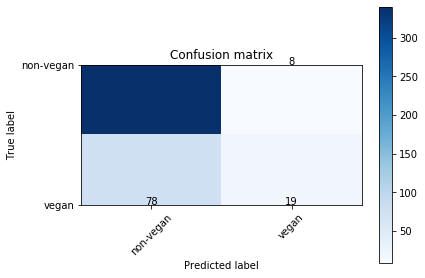

In [21]:
plot_confusion_matrix(confusion_matrix, ['non-vegan', 'vegan'])

Normalized confusion matrix


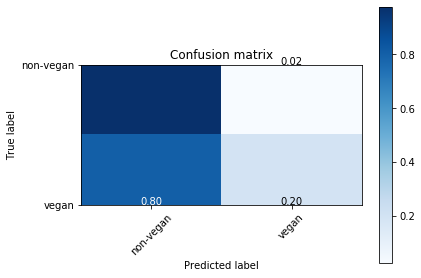

In [22]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['non-vegan', 'vegan'],
                     normalize=True)